# 2022-03 DoD Training

Outline

1. The Grants data model - quick walkthrough
2. Useful queries from a Funder GRID ID
3. Querying using arbitrary lists of IDs
  

## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the [API LAB](https://api-lab.dimensions.ai/) *Getting Started* tutorials.


In [183]:
!pip install dimcli --quiet 

import dimcli
from dimcli.utils import *
import json
import sys
import pandas as pd

import plotly.express as px
from IPython.display import Image

print("==\nLogging in..")

ENDPOINT = "https://app.dimensions.ai"

if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login()

dsl = dimcli.Dsl()

Searching config file credentials for default 'live' instance..


==
Logging in..
Dimcli - Dimensions API Client (v0.9.6)
Connected to: <https://app.dimensions.ai/api/dsl/v2> - DSL v2.0
Method: dsl.ini file


## PART 1. The grants data model - quick walkthrough


Fields reference: https://docs.dimensions.ai/dsl/datasource-grants.html

### 1.1 Dimensions grant `ID` VS 'original' `grant_number`

In [ ]:
%%dsldf

search grants 
    for "detector AND chemicals" 
return grants[id+grant_number+title] limit 5

Once you have the IDs, you can search using them - especially when using related models e.g. publications, patents etc.. (more on this in the next section).

In [152]:
%%dsldf

search grants 
    where id in ["grant.9971026", "grant.9967366"]
    or grant_number in ["ST/W000830/1", "2151709", "201547"]
return grants[id+grant_number+title] 

Returned Grants: 5 (total = 5)
Time: 0.63s


,grant_number,id,title
0,2143485,grant.9971026,CAREER: Going Beyond Linear Models for Attack ...
1,2150517,grant.9967366,REU Site: Multidisciplinary Underground Scienc...
2,ST/W000830/1,grant.9971907,"A Programme of Technology, Astrophysics and Co..."
3,2151709,grant.9971074,I-Corps: A fluorescence sensor for early detec...
4,201547,grant.9993718,"Quantum-limited metrology, transduction and ge..."


### 1.2 Field types: atomic data type (`funding_org_name`)  VS lists (`funder_countries`) VS entities (eg `funders`)

In [153]:
%%dsldf

search grants 
    for "detector AND chemicals" 
return grants[id+funding_org_name+funder_countries+funders] limit 5

Returned Grants: 5 (total = 4323)
Time: 0.57s


,funder_countries,funders,funding_org_name,id
0,"[{'id': 'US', 'name': 'United States'}]","[{'acronym': 'NSF ENG', 'city_name': 'Arlingto...",Directorate for Engineering,grant.9971026
1,"[{'id': 'US', 'name': 'United States'}]","[{'acronym': 'NSF MPS', 'city_name': 'Arlingto...",Directorate for Mathematical & Physical Sciences,grant.9967366
2,"[{'id': 'GB', 'name': 'United Kingdom'}]","[{'acronym': 'STFC', 'city_name': 'Swindon', '...",Science and Technology Facilities Council,grant.9971907
3,"[{'id': 'US', 'name': 'United States'}]","[{'acronym': 'NSF ENG', 'city_name': 'Arlingto...",Directorate for Engineering,grant.9971074
4,"[{'id': 'CH', 'name': 'Switzerland'}]","[{'acronym': 'SNF', 'city_name': 'Bern', 'coun...",Swiss National Science Foundation,grant.9993718


Use `unnest(funders)` or `unnest(funder_countries)` to unpack the contents of complex fields (docs:https://docs.dimensions.ai/dsl/language.html#unnesting-multi-value-entity-fields)

In [154]:
%%dsldf

search grants 
    for "detector AND chemicals" 
return grants[id+funding_org_name+unnest(funder_countries)] limit 5

Returned objects: 5 (total grants= 4323)
Time: 0.69s


,funder_countries.id,funder_countries.name,funding_org_name,id
0,US,United States,Directorate for Engineering,grant.9971026
1,US,United States,Directorate for Mathematical & Physical Sciences,grant.9967366
2,GB,United Kingdom,Science and Technology Facilities Council,grant.9971907
3,US,United States,Directorate for Engineering,grant.9971074
4,CH,Switzerland,Swiss National Science Foundation,grant.9993718


In [155]:
%%dsldf

search grants 
    for "detector AND chemicals" 
return grants[id+unnest(funders)] limit 5

Returned objects: 5 (total grants= 4323)
Time: 0.74s


,funders.acronym,funders.city_name,funders.country_name,funders.id,funders.latitude,funders.linkout,funders.longitude,funders.name,funders.state_name,funders.types,id
0,NSF ENG,Arlington,United States,grid.457810.f,38.880580,[http://www.nsf.gov/dir/index.jsp?org=ENG],-77.111000,Directorate for Engineering,Virginia,[Government],grant.9971026
1,NSF MPS,Arlington,United States,grid.457875.c,38.880566,[http://www.nsf.gov/dir/index.jsp?org=MPS],-77.110990,Directorate for Mathematical & Physical Sciences,Virginia,[Government],grant.9967366
2,STFC,Swindon,United Kingdom,grid.14467.30,51.566532,[http://www.stfc.ac.uk/],-1.785539,Science and Technology Facilities Council,NaN,[Government],grant.9971907
3,NSF ENG,Arlington,United States,grid.457810.f,38.880580,[http://www.nsf.gov/dir/index.jsp?org=ENG],-77.111000,Directorate for Engineering,Virginia,[Government],grant.9971074
4,SNF,Bern,Switzerland,grid.425888.b,46.949230,[http://www.snf.ch/en],7.432395,Swiss National Science Foundation,NaN,[Government],grant.9993718


### 1.3 Funder GRID identifiers (`funders.id`)


Let's find the GRID identifier we are interested in, using the [organizations API](https://docs.dimensions.ai/dsl/datasource-organizations.html)). 

In [156]:
%%dsldf

search organizations for "Department of Defense" 
    where country_name="United States" and types in ["Government"]
return organizations limit 100

Returned Organizations: 2 (total = 2)
Time: 0.73s


,city_name,country_name,id,latitude,linkout,longitude,name,state_name,types,acronym
0,Honolulu,United States,grid.448529.6,21.261510,[http://dod.hawaii.gov/],-157.79582,Hawaii Department of Defense,Hawaii,[Government],NaN
1,Washington D.C.,United States,grid.420391.d,38.871113,[http://www.defense.gov/],-77.05583,United States Department of Defense,District of Columbia,[Government],USDOD


Now let's find **grants** data using `grid.420391.d`

In [157]:
%%dsldf

search grants for "detector AND chemicals" 
    where funders.id = "grid.420391.d"
return grants limit 5

Returned Grants: 5 (total = 67)
Time: 0.52s


,active_year,end_date,funders,funding_org_name,grant_number,id,language,original_title,start_date,start_year,title
0,"[2019, 2020, 2021]",2021-08-07,"[{'acronym': 'USDOD ', 'city_name': 'Washingto...",United States Department of Defense,W911-SR-19-C-0033,grant.9526622,en,MicroLens Hyperspectral Imager for Standoff Ch...,2019-08-08,2019,MicroLens Hyperspectral Imager for Standoff Ch...
1,"[2019, 2020, 2021]",2021-07-18,"[{'acronym': 'USDOD ', 'city_name': 'Washingto...",United States Department of Defense,W911-NF-19-C-0068,grant.9526646,en,Detection of “active” biological toxins by exp...,2019-07-19,2019,Detection of “active” biological toxins by exp...
2,[2019],2019-07-27,"[{'acronym': 'USDOD ', 'city_name': 'Washingto...",United States Department of Defense,W911QY-19-P-0011,grant.9526613,en,"High stretch, environmentally robust hybridsil...",2019-01-28,2019,"High stretch, environmentally robust hybridsil..."
3,"[2018, 2019, 2020]",2020-11-20,"[{'acronym': 'USDOD ', 'city_name': 'Washingto...",United States Department of Defense,W911SR-19-C-0003,grant.9526626,en,Photoacoustic Gasses Optical Detector and Anal...,2018-11-21,2018,Photoacoustic Gasses Optical Detector and Anal...
4,"[2018, 2019, 2020]",2020-11-20,"[{'acronym': 'USDOD ', 'city_name': 'Washingto...",United States Department of Defense,W911SR-19-C-0003,grant.8579322,en,Photoacoustic Gasses Optical Detector and Anal...,2018-11-21,2018,Photoacoustic Gasses Optical Detector and Anal...


## PART 2. Useful queries using a Funder GRID identifier

In [158]:
Image(url= "https://docs.dimensions.ai/dsl/_images/data-model-grants.png", width=1000)

### 2.1 How many grants? 

The total number of results should match [what you see in Dimensions](https://app.dimensions.ai/discover/publication?search_mode=content&and_facet_funder=grid.420391.d).


In [159]:
%%dsldf

search grants 
    where funders.id = "grid.420391.d"
return grants[id+title]

Returned Grants: 20 (total = 2436)
Time: 0.58s


,id,title
0,grant.9785941,Rethinking Mathematics through the Integration...
1,grant.9881724,The Knowing and Embracing World Languages (KEW...
2,grant.9881723,Project H.E.L.L.O
3,grant.9881722,VBCPS Spanish Immersion Expansion Project
4,grant.9881721,PASSPORT
5,grant.9881720,Computer Science for All
6,grant.9881719,STEALTH Sciences
7,grant.9881718,"Bilingual, Biliterate, Bicultural Pathways to ..."
8,grant.9881717,Healthy Knights
9,grant.9881716,Future Ready with Biomedical Innovation


### 2.2 Downloading all grants records 

We can use a little Python and the `query_iterative` method. 


In [160]:
%%dslloopdf

search grants 
    where funders.id = "grid.420391.d"
return grants[id+title]

Starting iteration with limit=1000 skip=0 ...
0-1000 / 2436 (0.64s)
1000-2000 / 2436 (0.63s)
2000-2436 / 2436 (0.63s)
===
Records extracted: 2436


,id,title
0,grant.9785941,Rethinking Mathematics through the Integration...
1,grant.9881724,The Knowing and Embracing World Languages (KEW...
2,grant.9881723,Project H.E.L.L.O
3,grant.9881722,VBCPS Spanish Immersion Expansion Project
4,grant.9881721,PASSPORT
...,...,...
2431,grant.4400529,Advanced Column and Accumulator for Low Power ...
2432,grant.4399002,Deve;opment of A Handheld Gas Chromatography/M...
2433,grant.4398776,Large Scale Production of Antibodies in Transg...
2434,grant.4398540,Water-Based Ensemble Coating


Save the data so that we can reuse it later. 

In [161]:
all_grants = dsl_last_results

### 2.3 Now that we have the query, we can experiment with other facets..

#### Top organizations

Change the final query bit to return `research_orgs`

In [162]:
%%dsldf 

search grants 
    where funders.id = "grid.420391.d"    
    and active_year >= 2010
return research_orgs 
aggregate funding
limit 1000

Returned Research_orgs: 522
Time: 0.76s


,city_name,count,country_name,funding,id,latitude,linkout,longitude,name,state_name,types,acronym
0,Chelmsford,61,United States,31414522.0,grid.455372.2,42.583550,[http://www.tritonsys.com/],-71.320570,Triton Systems (United States),Massachusetts,[Company],NaN
1,Torrance,56,United States,23063305.0,grid.281112.9,33.845474,[http://www.poc.com/],-118.311950,Physical Optics Corporation,California,[Company],POC
2,Roanoke,41,United States,14837525.0,grid.281080.3,37.256560,[http://lunainc.com/],-79.942635,Luna Innovations (United States),Virginia,[Company],NaN
3,Huntsville,40,United States,21112784.0,grid.282058.5,34.726910,[http://www.cfdrc.com/],-86.690810,CFD Research Corporation (United States),Alabama,[Company],NaN
4,College Station,35,United States,17137067.0,grid.280661.b,30.614262,[http://www.lynntech.com/],-96.291930,Lynntech (United States),Texas,[Company],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
517,San Diego,1,United States,1499826.0,grid.505480.c,32.830870,[http://www.venator-solutions.com],-117.132560,Venator Solutions (United States),California,[Company],NaN
518,Dallas,1,United States,149850.0,grid.505488.4,32.986225,[http://www.vulintus.com/],-96.757140,Vulintus (United States),Texas,[Company],NaN
519,Tampa,1,United States,150000.0,grid.509583.2,27.966760,[https://www.shrinershospitalsforchildren.org/...,-82.568830,Shriners Hospitals for Children,Florida,[Healthcare],SHC
520,Ithaca,1,United States,367305.0,grid.5386.8,42.448510,[http://www.cornell.edu/],-76.478620,Cornell University,New York,[Education],CU


In [ ]:
px.scatter(dsl_last_results[:100], y="funding", 
               x="name", 
              color="state_name", 
              size="count", 
              height=900,
              title="Funded organizations overview")

#### Top Countries

Change the last query bit to return `research_org_countries`

In [164]:
%%dsldf 

search grants 
    where funders.id = "grid.420391.d"    
    and active_year >= 2010
return research_org_countries limit 1000

Returned Research_org_countries: 6
Time: 0.53s


,count,id,name
0,1797,US,United States
1,2,GB,United Kingdom
2,2,MW,Malawi
3,2,PE,Peru
4,1,FR,France
5,1,ZA,South Africa


#### Who is getting funded outside the US?

Use the filter `research_org_countries.name != "United States"`

In [165]:
%%dsldf 

search grants 
    where funders.id = "grid.420391.d"    
    and active_year >= 2010
    and research_org_countries.name != "United States"
return research_orgs limit 1000

Returned Research_orgs: 3
Time: 0.54s


,acronym,city_name,count,country_name,id,latitude,linkout,longitude,name,types,state_name
0,UPCH,Lima,2,Peru,grid.11100.31,-12.023458,[http://www.upch.edu.pe/portal/],-77.056790,Cayetano Heredia University,[Education],NaN
1,UNIMA,Zomba,1,Malawi,grid.10595.38,-15.389210,[http://www.unima.mw/],35.337170,University of Malawi,[Education],Nkhotakota
2,CABI,Wallingford,1,United Kingdom,grid.418543.f,51.590140,[http://www.cabi.org/],-1.118835,CAB International,[Nonprofit],NaN


#### How do I see the specific grants information?

Eg if I want to follow up on those non-US grants

In [166]:
%%dsldf 

search grants 
    where funders.id = "grid.420391.d"    
    and active_year >= 2010
    and research_org_countries.name != "United States"
return grants[id+dimensions_url+active_year+funding_org_name+funding_usd+grant_number+title+unnest(research_org_countries)+unnest(research_org_names)+research_orgs] limit 1000

Returned objects: 8 (total grants= 8)
Time: 0.62s


,active_year,dimensions_url,funding_org_name,funding_usd,grant_number,id,research_org_countries.id,research_org_countries.name,research_org_names,research_orgs,title
0,"[2019, 2020, 2021, 2022, 2023]",https://app.dimensions.ai/details/grant/grant....,United States Department of Defense,760000.0,N681712010002,grant.8684849,PE,Peru,Cayetano Heredia University,"[{'acronym': 'UPCH', 'city_name': 'Lima', 'cou...",HIV/AIDS Prevention Program Peru
1,"[2016, 2017, 2018]",https://app.dimensions.ai/details/grant/grant....,United States Department of Defense,300000.0,N681711610002,grant.7079883,MW,Malawi,BAOBAB HEALTH TRUST (BHT),NaN,HIV/AIDS Prevention Program Malawi
2,"[2016, 2017, 2018]",https://app.dimensions.ai/details/grant/grant....,United States Department of Defense,94481.0,W9132T1610001,grant.7916652,GB,United Kingdom,CAB International,"[{'acronym': 'CABI', 'city_name': 'Wallingford...",Biological control of Common reed (Phragmites ...
3,[2015],https://app.dimensions.ai/details/grant/grant....,United States Department of Defense,61342.0,N681711510034,grant.7079857,GB,United Kingdom,SIEMAN BIO - MEDICAL SOLUTIONS,NaN,HIV/AIDS PREVENTION PROGRAM MALAWI
4,"[2015, 2016, 2017, 2018, 2019]",https://app.dimensions.ai/details/grant/grant....,United States Department of Defense,75105.0,N681711510023,grant.7079846,FR,France,LA MANT e BUSINESS SOLUTIONS,NaN,HIV/AIDS PREVENTION PROGRAM LESOTHO
5,"[2015, 2016, 2017]",https://app.dimensions.ai/details/grant/grant....,United States Department of Defense,150000.0,N681711510029,grant.7079852,ZA,South Africa,Foundation for Professional Development (FPD),NaN,HIV/AIDS Prevention Program South africa
6,"[2015, 2016, 2017, 2018, 2019]",https://app.dimensions.ai/details/grant/grant....,United States Department of Defense,600000.0,N681711510018,grant.7079841,PE,Peru,Cayetano Heredia University,"[{'acronym': 'UPCH', 'city_name': 'Lima', 'cou...",HIV/AIDS Prevention Program Peru
7,"[2013, 2014, 2015]",https://app.dimensions.ai/details/grant/grant....,United States Department of Defense,6000.0,N681711510010,grant.7079835,MW,Malawi,University of Malawi,"[{'acronym': 'UNIMA', 'city_name': 'Zomba', 'c...",HIV/AIDS Prevention Program Malawi


#### Top Researchers


In [167]:
%%dsldf 

search grants 
    where funders.id = "grid.420391.d"    
    and active_year >= 2010
return researchers[basics+current_research_org] limit 1000

Returned Researchers: 1000
Time: 0.78s


,count,current_research_org,first_name,id,last_name,research_orgs,orcid_id
0,12,grid.281034.c,Girish Srinivas D Girish,ur.01042700104.17,Srinivas,[grid.281034.c],NaN
1,12,grid.281233.9,Odile H,ur.0634432601.12,Clavier,"[grid.281233.9, grid.134563.6, grid.63054.34, ...",[0000-0003-4439-4120]
2,11,grid.281112.9,Gregory,ur.01255365415.60,Zeltser,[grid.281112.9],NaN
3,10,grid.455372.2,Rod,ur.01153237207.46,Jose,[grid.455372.2],NaN
4,9,grid.455372.2,Sarena,ur.015111714317.18,Horava,[grid.455372.2],NaN
...,...,...,...,...,...,...,...
995,1,NaN,Jason,ur.015323741407.21,Zhou,NaN,NaN
996,1,grid.422612.1,Luis,ur.015325455707.17,Echevarria,[grid.422612.1],NaN
997,1,grid.479364.b,Terri,ur.015334455543.55,Dodson-Caldevilla,[grid.479364.b],NaN
998,1,NaN,Bran,ur.015334540471.01,Ferren,"[grid.455230.5, grid.21729.3f]",NaN


### 2.4 Getting Publications from a funder ID


We can use the field `funders`,  which is a direct link from Publications to Funder Organizations (a 'shortcut'), using the funders IDs. 


In [168]:
%%dsldf 

search publications 
    where funders.id = "grid.420391.d"
return publications[id+title+year+unnest(supporting_grant_ids)]


Returned objects: 29 (total publications= 35990)
Time: 0.55s


,id,title,year,supporting_grant_ids
0,pub.1144759864,Analyzing Trajectory Gaps to Find Possible Ren...,2022,NaN
1,pub.1145403691,Near real-time hurricane rainfall forecasting ...,2022,grant.9214518
2,pub.1145236788,On the indecomposability of a remarkable new f...,2022,NaN
3,pub.1144186126,A case study on parallel HDF5 dataset concaten...,2022,grant.7824141
4,pub.1144186126,A case study on parallel HDF5 dataset concaten...,2022,grant.4320132
5,pub.1145751220,In vivo MRI evaluation of anterograde manganes...,2022,grant.2439145
6,pub.1145751220,In vivo MRI evaluation of anterograde manganes...,2022,grant.7073043
7,pub.1145428082,A contextualized comprehensive action determin...,2022,grant.8326729
8,pub.1145428082,A contextualized comprehensive action determin...,2022,grant.8868775
9,pub.1145368233,Surprise is inevitable: How do we train and pr...,2022,NaN


In [169]:
pubs = dsl_last_results

Now we can retrieve the associated grants. 




In [170]:
temp = pubs.dropna(subset=['supporting_grant_ids'])
grantids = temp['supporting_grant_ids'].to_list()

query = f"""
search grants 
    where id in {json.dumps(grantids)}
return grants[id+title+funders]
"""

linkedgrants = dsl.query(query).as_dataframe()
linkedgrants

Returned Grants: 19 (total = 19)
Time: 0.54s


,funders,id,title
0,"[{'acronym': 'NSF MPS', 'city_name': 'Arlingto...",grant.9621309,REU Site: Characterization of Materials Using ...
1,"[{'acronym': 'NSF OD', 'city_name': 'Arlington...",grant.9214518,RII Track-1: Socially Sustainable Solutions fo...
2,"[{'acronym': 'OSD', 'city_name': 'Washington D...",grant.9183631,Development of a Novel PFAS Passive Sampler wi...
3,"[{'acronym': 'NSF ENG', 'city_name': 'Arlingto...",grant.8832885,Collaborative Research: Physical Mechanism of ...
4,"[{'acronym': 'NSF ENG', 'city_name': 'Arlingto...",grant.8832450,Characterizing the Dynamics of the Laser Metal...
5,"[{'acronym': 'NSF MPS', 'city_name': 'Arlingto...",grant.8541254,Fast X-ray Microscopy to Quantify the Nucleati...
6,"[{'acronym': 'NSFC', 'city_name': 'Beijing', '...",grant.8868775,"User experience, deep use and out-of-role beha..."
7,"[{'acronym': 'NSF CISE', 'city_name': 'Arlingt...",grant.7734473,Collaborative Research: NSCI Framework: Softwa...
8,"[{'acronym': 'BES', 'city_name': 'Washington D...",grant.7824151,Physics-Based Multiscale Additively Manufactur...
9,"[{'acronym': 'ASCR', 'city_name': 'Washington ...",grant.7824141,PROTEUS: Machine Learning Driven Resilience fo...


### 2.5 Getting Patents from a funder ID

In [171]:
%%dsldf 

search patents 
    where funders.id = "grid.420391.d"
return patents[id+title+year+unnest(associated_grant_ids)]


Returned objects: 29 (total patents= 4800)
Time: 0.58s


,id,title,year,associated_grant_ids
0,US-RE43000-E1,Artificial riboswitch for controlling pre-mRNA...,2010,NaN
1,US-RE41748-E1,Tunable bragg grating and devices employing th...,2009,NaN
2,US-RE41613-E1,Tunable bragg grating devices employing the same,2006,NaN
3,US-RE39707-E1,Camptothecin derivatives,2003,NaN
4,US-9999684-B2,Methods of treating neurodegenerative disorders,2017,NaN
5,US-9997883-B1,Apparatuses and methods for reducing risk of b...,2017,NaN
6,US-9997705-B2,Porous SiOx materials for improvement in SiOx ...,2014,NaN
7,US-9992048-B2,Systems and methods for detecting unused commu...,2016,NaN
8,US-9988617-B2,Engineered heme-binding compositions and uses ...,2014,NaN
9,US-9984143-B2,"System and method for resource-adaptive, real-...",2015,NaN


## 3. Querying using arbitrary lists of IDs 

See also these tutorials

* [Enriching Grants part 2: Adding Publications Information from Dimensions](https://api-lab.dimensions.ai/cookbooks/3-grants/2-grants-enrichment-adding-publications-information.html#)
* [Working with longs lists of IDs](https://api-lab.dimensions.ai/cookbooks/1-getting-started/6-Working-with-lists.html#5.-How-Long-can-lists-get?)

### 3.1 From grants to other entities: the links available

In [172]:
Image(url= "https://docs.dimensions.ai/dsl/_images/data-model-overview-1.png", width=1000)

### 3.2 Example: Patents funders analysis 

Example - we want to get an overview of who's funded patents on a specific topic. 

**Two steps**

* first, we create a patents dataset using any criteria of choice
* second, we find associated grants for those patents/grants IDs
    * since we can have a large number of IDs, we need to pay attention to the API query 'size' 

In [173]:
%%dslloopdf

search patents 
    for "detection AND explosives"
    where year >= 2000
    and associated_grant_ids is not empty
return patents[id+title+year+unnest(associated_grant_ids)]

Starting iteration with limit=1000 skip=0 ...
0-1000 / 1634 (0.72s)
1000-1634 / 1634 (1.51s)
1634-1634 / 1634 (2.05s)
===
Records extracted: 2592


,associated_grant_ids,id,title,year
0,grant.4294962,WO-2020260475-A1,TRANSFERASE ENZYMES,2020
1,grant.6944574,WO-2020217046-A1,SYSTEMS AND METHODS USING ACTIVE FTIR SPECTROS...,2020
2,grant.3861585,WO-2018138498-A1,NON-TARGET SITE RESISTANCE,2018
3,grant.4106834,WO-2018015309-A1,RAMAN SPECTROSCOPY,2017
4,grant.5073163,WO-2017021424-A1,GAS PHASE FLUORESCENCE ANALYSIS,2016
...,...,...,...,...
2587,grant.3560299,DE-102016114440-B3,SERS substrate and method of making a SERS sub...,2016
2588,grant.2784092,AU-2010308169-B2,Intelligent pigments and plastics,2010
2589,grant.2778641,AU-2010308169-B2,Intelligent pigments and plastics,2010
2590,grant.2778641,AU-2010308169-A1,Intelligent pigments and plastics,2010


In [174]:
patents = dsl_last_results

In [175]:
# we get grants for those patents, by segmenting the associated_grant_ids list into groups of 300 IDs
# this is because each DSL query can take max ~300 IDs at a time 

from tqdm.notebook import tqdm as progressbar
associated_grant_ids = dsl_last_results['associated_grant_ids'].to_list()


#
# the main API query
#
q = """search grants
          where id in {}
       return grants[id+dimensions_url+researchers+title+active_year+funding_usd+funding_org_name+unnest(funder_countries)+unnest(research_org_countries)+unnest(research_org_names)]"""


#
# let's loop through all IDs in chunks and query Dimensions
#
results = []
for chunk in progressbar(list(chunks_of(list(associated_grant_ids), 300))):
    data = dsl.query_iterative(q.format(json.dumps(chunk)), verbose=True)
    results += data.grants
    time.sleep(1)
    
    

#
# put the data into a dataframe, remove duplicates and save
#
grants = pd.DataFrame().from_dict(results)
print("Grants: ", len(grants))
grants.drop_duplicates(subset='id', inplace=True)
print("Unique Grants: ", len(grants))

#
# preview
#
print("Example:")
grants.head(5)

  0%|          | 0/9 [00:00<?, ?it/s]

Starting iteration with limit=1000 skip=0 ...
0-237 / 237 (4.14s)
237-237 / 237 (0.59s)
===
Records extracted: 10728
Starting iteration with limit=1000 skip=0 ...
0-203 / 203 (3.90s)
203-203 / 203 (0.96s)
===
Records extracted: 215
Starting iteration with limit=1000 skip=0 ...
0-213 / 213 (2.47s)
213-213 / 213 (0.62s)
===
Records extracted: 226
Starting iteration with limit=1000 skip=0 ...
0-216 / 216 (0.93s)
216-216 / 216 (0.63s)
===
Records extracted: 246
Starting iteration with limit=1000 skip=0 ...
0-203 / 203 (1.17s)
203-203 / 203 (0.65s)
===
Records extracted: 219
Starting iteration with limit=1000 skip=0 ...
0-226 / 226 (0.86s)
226-226 / 226 (0.63s)
===
Records extracted: 682
Starting iteration with limit=1000 skip=0 ...
0-198 / 198 (0.71s)
198-198 / 198 (0.67s)
===
Records extracted: 212
Starting iteration with limit=1000 skip=0 ...
0-238 / 238 (1.21s)
238-238 / 238 (0.64s)
===
Records extracted: 265
Starting iteration with limit=1000 skip=0 ...
0-148 / 148 (1.09s)
148-148 / 14

Grants:  13583
Unique Grants:  905
Example:


,active_year,dimensions_url,funder_countries.id,funder_countries.name,funding_org_name,funding_usd,id,research_org_countries.id,research_org_countries.name,research_org_names,researchers,title
0,"[2019, 2020, 2021, 2022]",https://app.dimensions.ai/details/grant/grant....,US,United States,Office of Basic Energy Sciences,6740681.0,grant.4319520,US,United States,University of Wisconsin–Madison,"[{'first_name': 'Max G', 'id': 'ur.0712201505....",Synthesis and Characterization of Composites o...
1,"[2017, 2018, 2019]",https://app.dimensions.ai/details/grant/grant....,GB,United Kingdom,Science and Technology Facilities Council,385858.0,grant.6944574,GB,United Kingdom,Heriot-Watt University,"[{'first_name': 'Derryck T', 'id': 'ur.0100256...",Drone-Assisted Fourier-Transform Spectroscopy ...
13,"[2016, 2017, 2018]",https://app.dimensions.ai/details/grant/grant....,GB,United Kingdom,Medical Research Council,1013080.0,grant.5073163,GB,United Kingdom,Newcastle University,"[{'first_name': 'David Emrys Jeffreys', 'id': ...",Newcastle Confidence in Concept 2015
16,"[2015, 2016, 2017, 2018, 2019]",https://app.dimensions.ai/details/grant/grant....,GB,United Kingdom,Science and Technology Facilities Council,223964.0,grant.4106834,GB,United Kingdom,University of Leicester,"[{'first_name': 'Jonathan Stephen', 'id': 'ur....",Linear Geiger Mode Detector Technology for Tim...
80,"[2015, 2016, 2017, 2018, 2019, 2020]",https://app.dimensions.ai/details/grant/grant....,US,United States,National Institute of Neurological Disorders a...,2995818.0,grant.7910079,US,United States,"ASTROCTYE PHARMACEUTICALS, INC.","[{'first_name': 'Theodore E', 'id': 'ur.011236...",Preclinical development of AST-004 for astrocy...


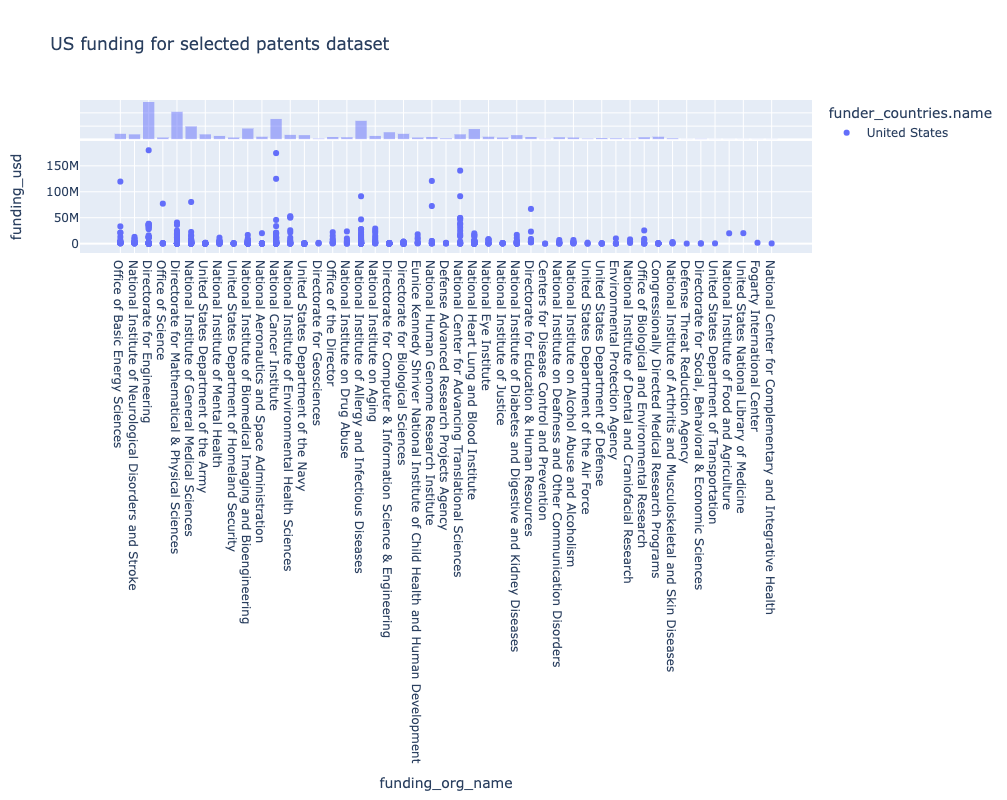

In [176]:
# fix empty values
grants.fillna(0, inplace=True) 

gsubset = grants[grants["funder_countries.name"] == 'United States']

px.scatter(gsubset,
           x="funding_org_name", 
           y="funding_usd", 
           marginal_x="histogram",
           color="funder_countries.name", 
           height=800,
           title="US funding for selected patents dataset")

### 3.3 Example: For a given list of DoD awards, how to find out if the awardees have awards from other funders?

**Approach: Three steps**

* first get all grants from DoD
* second get all awards for those researchers (not just the DoD ones)
* third, keep only the non-DoD awards

In [177]:
grants  = dsl.query_iterative(f"""
search grants 
    where funders.id = "grid.420391.d"
return grants[id+title+grant_number+researchers] 
""").as_dataframe()

grants.head(5)

Starting iteration with limit=1000 skip=0 ...
0-1000 / 2436 (1.15s)
1000-2000 / 2436 (1.15s)
2000-2436 / 2436 (0.69s)
===
Records extracted: 2436


,grant_number,id,researchers,title
0,HE12542110005,grant.9785941,"[{'first_name': 'Robert', 'id': 'ur.0163534066...",Rethinking Mathematics through the Integration...
1,HE12542112007,grant.9881724,"[{'first_name': 'Denny', 'id': 'ur.01362142504...",The Knowing and Embracing World Languages (KEW...
2,HE12542112004,grant.9881723,"[{'first_name': 'Helen', 'id': 'ur.01347571321...",Project H.E.L.L.O
3,HE12542112003,grant.9881722,"[{'first_name': 'Katie A', 'id': 'ur.012700332...",VBCPS Spanish Immersion Expansion Project
4,HE12542112002,grant.9881721,"[{'first_name': 'Denise', 'id': 'ur.0121027522...",PASSPORT


In [178]:
# ignore grants with no researchers info
grants.dropna(subset=['researchers'], inplace=True)

# get the IDS only
researchers = set()

for index, row in grants.iterrows():
    res = [el['id'] for el in row['researchers']]
    researchers.update(res)

print("Unique researchers: ", len(researchers))

Unique researchers:  1490


In [179]:
# we get grants for all researchers, by segmenting the researchers list into groups of 300 IDs
# this is because each DSL query can take max ~300 researchers at a time 

from tqdm.notebook import tqdm as progressbar
researcher_ids = researchers

#
# TRIAL RUN: Uncomment this line to use less researchers and speed things up
#
# researcher_ids= researcher_ids[:200]


#
# the main API query
#
q = """search grants
          where researchers in {}
       return grants[id+dimensions_url+researchers+title+active_year+funding_usd+funding_org_name+unnest(funder_countries)+unnest(research_org_countries)+unnest(research_org_names)]"""


#
# let's loop through all researcher IDs in chunks and query Dimensions
#
results = []
for chunk in progressbar(list(chunks_of(list(researcher_ids), 200))):
    data = dsl.query_iterative(q.format(json.dumps(chunk)), verbose=True)
    results += data.grants
    time.sleep(1)

#
# put the data into a dataframe, remove duplicates and save
#
grants = pd.DataFrame().from_dict(results)
print("Grants: ", len(grants))
grants.drop_duplicates(subset='id', inplace=True)
print("Unique Grants: ", len(grants))

#
# preview
#
print("Example:")
grants.head(5)

  0%|          | 0/8 [00:00<?, ?it/s]

Starting iteration with limit=1000 skip=0 ...
0-1000 / 1286 (1.07s)
1000-1286 / 1286 (0.84s)
1286-1286 / 1286 (0.65s)
===
Records extracted: 1926
Starting iteration with limit=1000 skip=0 ...
0-1000 / 1690 (1.16s)
1000-1690 / 1690 (1.51s)
1690-1690 / 1690 (0.59s)
===
Records extracted: 2670
Starting iteration with limit=1000 skip=0 ...
0-1000 / 1608 (1.55s)
1000-1608 / 1608 (1.15s)
1608-1608 / 1608 (0.59s)
===
Records extracted: 2405
Starting iteration with limit=1000 skip=0 ...
0-1000 / 1695 (1.56s)
1000-1695 / 1695 (1.13s)
1695-1695 / 1695 (0.58s)
===
Records extracted: 2923
Starting iteration with limit=1000 skip=0 ...
0-1000 / 1883 (1.57s)
1000-1883 / 1883 (1.07s)
1883-1883 / 1883 (0.65s)
===
Records extracted: 2716
Starting iteration with limit=1000 skip=0 ...
0-1000 / 1542 (1.43s)
1000-1542 / 1542 (1.24s)
1542-1542 / 1542 (0.55s)
===
Records extracted: 2320
Starting iteration with limit=1000 skip=0 ...
0-1000 / 1914 (1.62s)
1000-1914 / 1914 (1.57s)
1914-1914 / 1914 (0.60s)
===
Re

Grants:  19482
Unique Grants:  12464
Example:


,active_year,dimensions_url,funder_countries.id,funder_countries.name,funding_org_name,funding_usd,id,research_org_countries.id,research_org_countries.name,research_org_names,researchers,title
0,"[2021, 2022, 2023, 2024, 2025, 2026]",https://app.dimensions.ai/details/grant/grant....,US,United States,United States Department of Defense,1000000.0,grant.9881720,US,United States,Monterey Peninsula Unified School District,"[{'first_name': 'Cresta', 'id': 'ur.0125641042...",Computer Science for All
1,"[2021, 2022, 2023, 2024, 2025, 2026]",https://app.dimensions.ai/details/grant/grant....,US,United States,United States Department of Defense,2342517.0,grant.9843160,US,United States,Coronado Unified School District,"[{'first_name': 'Stacy', 'id': 'ur.01102232365...",World Language Plus
2,"[2021, 2022, 2023, 2024, 2025, 2026]",https://app.dimensions.ai/details/grant/grant....,US,United States,United States Department of Defense,750000.0,grant.9785949,US,United States,Belle Chasse Academy,"[{'first_name': 'Lauran', 'id': 'ur.0150265610...",Belle Chasse Academy Grant
3,"[2021, 2022]",https://app.dimensions.ai/details/grant/grant....,US,United States,National Institute of Neurological Disorders a...,256364.0,grant.9847720,US,United States,Vulintus (United States),"[{'first_name': 'Andrew Michael', 'id': 'ur.01...",SensiTrak: Automated Assessment of Forelimb Se...
4,"[2021, 2022]",https://app.dimensions.ai/details/grant/grant....,US,United States,National Human Genome Research Institute,399999.0,grant.9847712,US,United States,Electronic BioSciences (United States),"[{'first_name': 'Eric Nathan', 'id': 'ur.01136...",Long-lived Platform Development for Exonucleas...


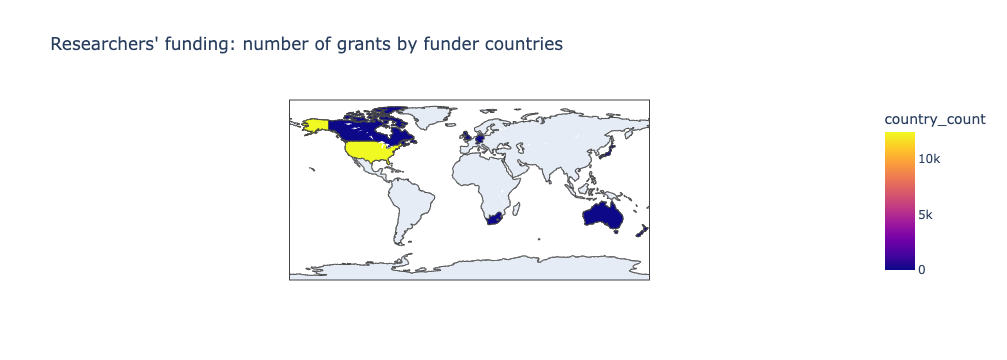

In [180]:
# fix empty values
grants.fillna(0, inplace=True) 
# add aggregated counts
grants['country_count'] = grants.groupby('funder_countries.name')['id'].transform('count')
grants['country_funding'] = grants.groupby('funder_countries.name')['funding_usd'].transform('sum')

gsubset = grants[['funder_countries.name', 'country_count']]
px.choropleth(gsubset.drop_duplicates(), 
                  locations="funder_countries.name",
                  locationmode="country names",
                  color="country_count", 
                  hover_name="funder_countries.name",
                  color_continuous_scale=px.colors.sequential.Plasma,
                  title="Researchers' funding: number of grants by funder countries")

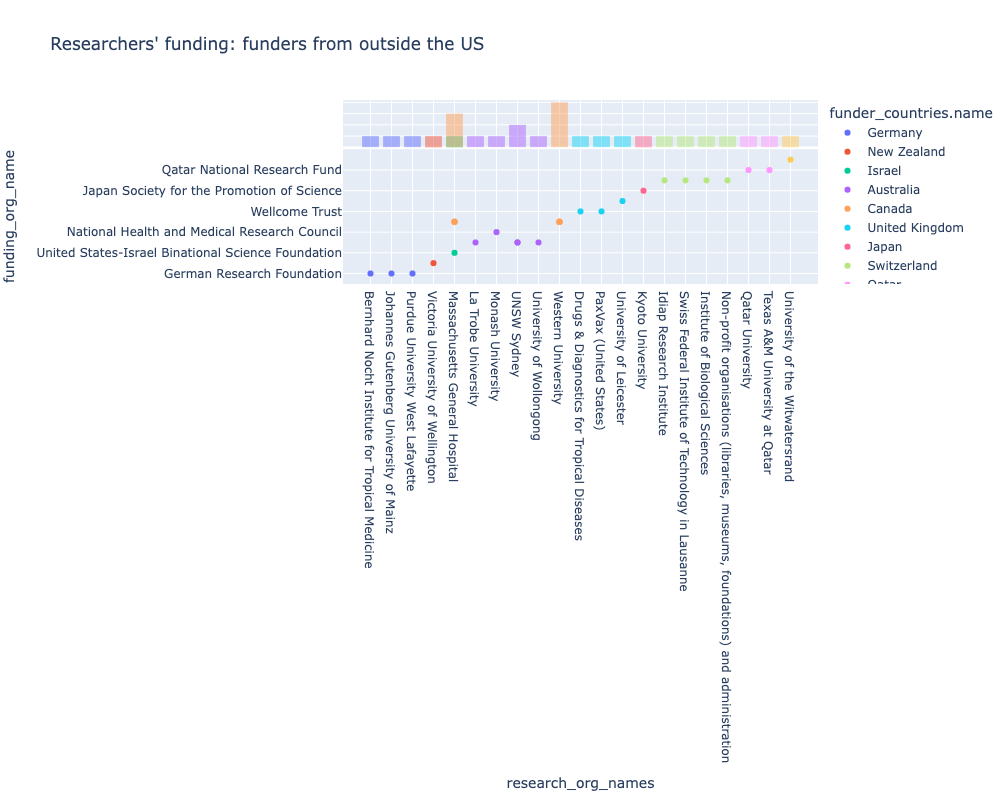

In [181]:
gsubset = grants[grants["funder_countries.name"] != 'United States']

px.scatter(gsubset,
           y="funding_org_name", 
           x="research_org_names", 
           marginal_x="histogram",
           color="funder_countries.name", 
           height=800,
           title="Researchers' funding: funders from outside the US")

#### To find out who are the researchers

In [182]:
# eg for Japan

COUNTRY = "Japan"

focus_set = grants[grants["funder_countries.name"] == COUNTRY]['researchers'].to_list()

for res in focus_set[0]:
    if res['id'] in researcher_ids:
        print(res['first_name'], res['last_name'], "\n", dimensions_url(res['id'], 'researchers'))

Jacob Joseph Loverich 
 https://app.dimensions.ai/discover/publication?and_facet_researcher=ur.01204664575.83


## More tutorials

* Doing this at scale: see the [Working with lists tutorial](https://api-lab.dimensions.ai/cookbooks/1-getting-started/6-Working-with-lists.html) that shows how to deal with list of researchers / grants of any size, using pagination and 'chunking' methods
* Makings the analysis more specific by using the [investigators details data structure](https://docs.dimensions.ai/dsl/datasource-grants.html#grants-investigators-long-desc) in the API grants model
* Going from grants to [Related publications](https://api-lab.dimensions.ai/cookbooks/3-grants/2-grants-enrichment-adding-publications-information.html)
* Going from grants to [Related Patents and Clinical Trials](https://api-lab.dimensions.ai/cookbooks/3-grants/3-grants-enrichment-adding-patents-cltrials-information.html)
